In [ ]:
# install library
# pip install pandas as pd
# pip insatll numpy as np
# pip install seaborn as sn
# pip install matplotlib as plt
# pip install mysql-connector-python

In [10]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('geolocation.csv', 'geolocation'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('sellers.csv','sellers'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='####',
    database='ecommerce'
)
cur = conn.cursor()

# Folder containing the CSV files
folder_path = 'E:/data execl/data anlyst projects/Ecommrece'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_descrip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect( host = "localhost",
                              username = "root",
                              password = "1810",
                              database = "ecommerce")

cur = db.cursor()

# list all unique cities where customers are located.    

In [15]:

query = """ select distinct customer_city  from customers"""

cur.execute(query)

data  = cur.fetchall()
df = pd.DataFrame(data,columns=["City"])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#  Count the number of order placed in 2017.           

In [13]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data = cur.fetchall()
##data
"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 45101)

# find the total sales per category. 

In [32]:
query = """ select p.product_category as category , round(sum(py.payment_value),2) as sales from products p
            join order_items as o
            on o.product_id=p.product_id
            join payments as py
            on py.order_id = o.order_id
            group by category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","total_sales"])
df

,category,total_sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.

In [48]:
query = """ select (sum(case when payment_installments>=1 then 1 
                            else 0 end ))/count(*)*100 from payments """
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# count the number of customers in each state 

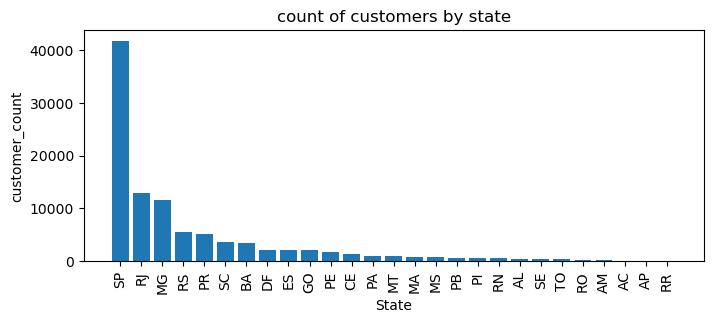

In [124]:
query = """ select count(*) as no_of_customer, customer_state from customers
            group by customer_state """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns = ["customer_count","state"])
df = df.sort_values(by = "customer_count", ascending = False)
plt.figure(figsize = (8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("customer_count")
plt.title("count of customers by state")
plt.show()

# calculate the numbers of orders per month in 2018.

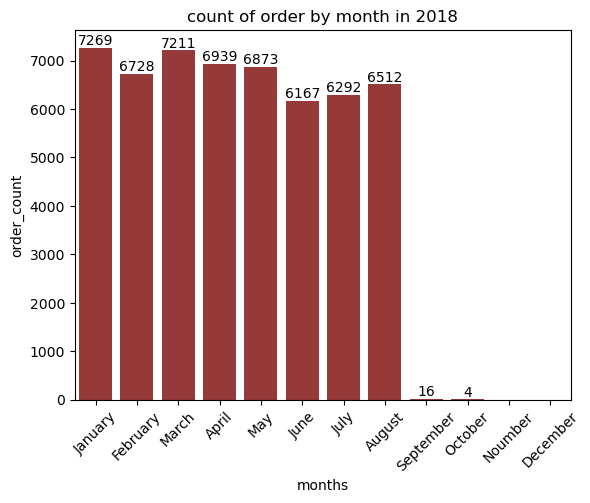

In [134]:
query = """ select monthname(order_purchase_timestamp) as months, count(*) as order_count from orders
            where year(order_purchase_timestamp)=2018
            group by months """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["months","order_count"])
df
o = ["January","February","March","April","May","June","July","August","September","October","Noumber","December"]
ax=sns.barplot(x=df["months"],y=df["order_count"],data= df,order = o ,color="brown")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("count of order by month in 2018")
plt.show()


# find the average number of products per order , grouped by customer city.

In [145]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["customer_cities","average_Product/order"])
df.head(10)

,customer_cities,average_Product/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# calculate the percentage of total revenue contributed by each product category.

In [150]:
query = """ select products.product_category category, round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales from products
join order_items 
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
order by sales desc; """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Product_Name","total_sales_percentage"])
df.head(10)

,Product_Name,total_sales_percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


# Identify the correlation between product price and the number of times a product has been purchased.

In [165]:
query = """ select products.product_category,count(order_items.order_id),round(avg(order_items.price),2) from products
            join order_items
            on products.product_id=order_items.product_id
            group by products.product_category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Category","order_count","average_price"])
df.head(10)

# checking the correlation
arr1= df["order_count"]
arr2 = df["average_price"]
np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

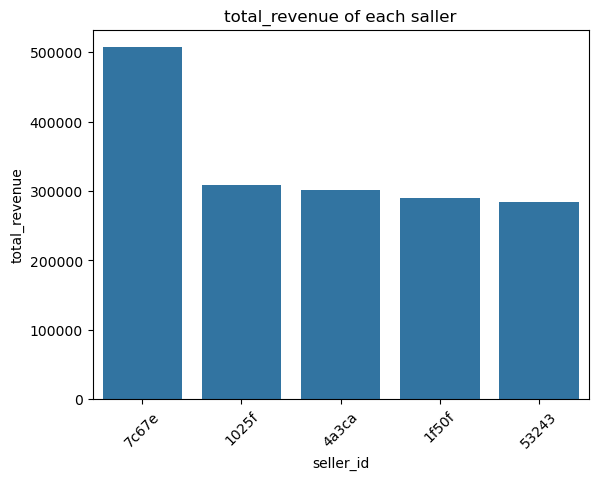

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
query = """ select *,dense_rank() over(order by revenue desc) as rnk from
            (select left(order_items.seller_id,5) ,round(sum(payments.payment_value),2) as revenue from order_items
            join payments
            on order_items.order_id=payments.order_id
            group by order_items.seller_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["seller_id","total_revenue","rank"])
df=df.head()
sns.barplot(x="seller_id", y="total_revenue", data=df)
plt.xticks(rotation=45)
plt.title("total_revenue of each saller")
plt.show()


# calculate the moving average of order values for each customer over their order history.

In [63]:
query = """ select customer_id,order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row ) as mov_avg
from 
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments 
join orders 
on payments.order_id = orders.order_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["customer_id","purchase_date","payment","moving_avg"])
df.head()

,customer_id,purchase_date,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# calculate the cumulative sales per month for each year.

In [102]:
query = """
    select years,months,payments,sum(payments)  
    over(order by years,months) as cumulative_payments from
         (select year(orders.order_purchase_timestamp) as years,
       month(orders.order_purchase_timestamp) as months ,
       round(sum(payments.payment_value),2) as payments
       from orders 
       join payments
       on orders.order_id=payments.order_id
       group by years,months order by years,months) as a
       """
cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data,columns=["year","month","payment","cumulative_sales"])

df

,year,month,payment,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# calculate the year-over-year growth rate of total sales.

In [109]:
query = """  with a as (select year(orders.order_purchase_timestamp) as years, sum(payments.payment_value) as payments
            from orders
            join payments
            on orders.order_id = payments.order_id
            group by years)
            select years,((payments-lag(payments,1) over(order by years))/lag(payments,1) over(order by years))*100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Year","Y-O-Y % growth"])
df

,Year,Y-O-Y % growth
0,2016,NaN
1,2017,12112.703760
2,2018,20.000924


In [ ]:
# calculate the 

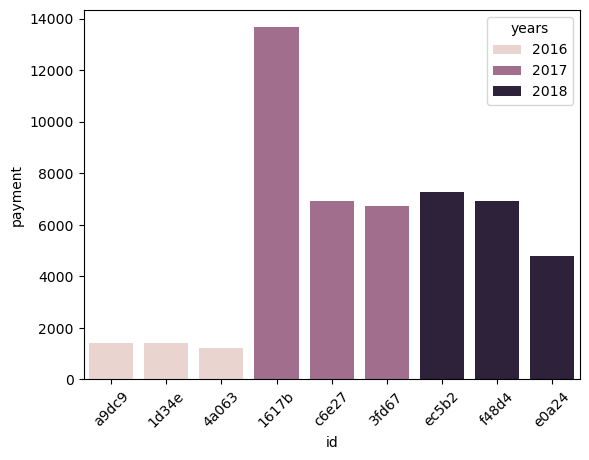

In [128]:
query = """
            select years,left(customer_id,5),payment,d_rank
            from
            (select  year(orders.order_purchase_timestamp) years,
            orders.customer_id,
            sum(payments.payment_value) payment,
            dense_rank() over(partition by year(orders.order_purchase_timestamp)
            order by sum(payments.payment_value ) desc ) d_rank
            from orders join payments
            on payments.order_id = orders.order_id
            group by year(orders.order_purchase_timestamp),
            orders.customer_id ) as a
            where d_rank<=3 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["years","id","payment","rank"])
sns.barplot(x="id",y="payment", data=df ,hue = "years")
plt.xticks(rotation =45)
plt.show()